<a href="https://colab.research.google.com/github/jiinjung/lunar-spectroscopy-toolkit/blob/main/ref2SSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
# This mounts your Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

# Enter the foldername in your Drive where you have saved 
FOLDERNAME = "lunar-spectroscopy"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that the Python interpreter of the Colab VM can load
import sys
syspath = '/content/drive/My Drive/{}'.format(FOLDERNAME)
sys.path.append(syspath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# 1) Basic Functions and Tools for Radiative Transfer Models

Next few blocks is a basic Hapke radiative transfer model functions and basic caculation tools for converting reflectance to single scattering albedo

This includes five functions: 


1) **Chandrasekhar(w , x)** : This function calculates Chandrasekar H function from Hapke radiative tranfer model
    Inputs: 1) w = SSA, 2) x = mu or mu_0
    Output: 1) H = corresponding Chandrasekar H-function

2) **phaseFunction(g)**: This function calculates phase function in the Hapke radiative transfer model, that how reflected energy changes with viewing directions. The value are from Pieters and Li lunar spectroscopy papers
    Inputs: 1) g = phase angle
    Outputs: 1) P(g) = phase function 
    
3) **backscatterFunction(g)**: This function calculates backscatter function in the Hapke radiative transfer model
    Inputs: 1) g = phase angle
    Outputs: 1) B(g) = backscattering function

4) **bisection (func, a, b, tolerance)**: This function takes function, initial input a, b and tolerance tol, and find the root based on the bisection method.
    Inputs: 1) func = function to find a root of zero 2) a = lowerlimit of the bisection range 3) b = upperlimit of the bisection range 4) tolerance 
    Outputs: 1) numerical answer from the bisection algorithm
    
5) **ssa2ref(w, mu_0, mu)**: This function calculates reflectance from the given SSA value
    Inputs: 1) w = SSA, 2) mu or mu_0 = cosines of incidence and emergence angles
    Output: 1) r = corresponding reflectance 


The Hapke radiative transfer model describes that the spectral reflectance relates to the single-scattering albedo (SSA) of mineral constituents.

\begin{align}
r = \frac{w}{4(\mu + \mu_0)}[(1 + B(g))P(g) + H(w, \mu)H(w, \mu_0) - 1],
\end{align}


where $w$, $\mu$, $\mu_0$, and $g$ are SSA, cosine of an incidence angle, and cosine of an emittance angle, respectively. $B$ is the backscattering function, $P$ is the phase function, and $H$ is the Chandrasekhar integral function. 

We can assume $B = 0$ (no backscattering at the phase angle measured), and $P = 1$ (isotropic scatters) for laboratory measurements, which gives:

\begin{align}
r = \frac{w}{4(\mu + \mu_0)} H(w, \mu)H(w, \mu_0),
\end{align}

For the latter case, function 3) and 4) will not be used

In [10]:
def Chandrasekhar(w , x):
    """
    This function calculates Chandrasekar H function from Hapke radiative tranfer model
    Inputs: 1) w = SSA, 2) x = mu or mu_0
    Output: 1) H = corresponding Chandrasekar H-function
    """

    gamma = np.sqrt(1 - w)
    r0 = (1 - gamma)/(1 + gamma)
    H = (1 - w * x * (r0 + (1 - 2 * r0 * x)/2 * np.log((1 + x) / x)))**(-1);
    
    return H

In [11]:
def phaseFunction(g):
    """
    This function calculates phase function in the Hapke radiative transfer model, that how reflected energy changes 
    with viewing directions. The value are from Pieters and Li lunar spectroscopy papers
    Inputs: 1) g = phase angle
    Ouputs: 1) P(g) = phase function
    """
    b = -0.4
    c = 0.25
    
    p_g = 1 + b * np.cos(np.radians(g)) + c * (1.5 * np.cos(np.radians(g))**2 - 0.5)
    
    return p_g

In [12]:
def backscatterFunction(g):
    """
    This function calculates backscatter function in the Hapke radiative transfer model
    Inputs: 1) g = phase angle
    Ouputs: 1) B(g) = backscattering function
    """
    
    h = -3/8 * np.log(1 - 0.41) 
    
    return 1 / (1 + (1/h)) * np.tan(np.radians(g / 2))

In [13]:
def bisection(func, a, b, tol): 
    """
    This function takes function, initial input a, b and tolerance tol,
    and find the root based on the bisection method 
    """
    fa = func(a)
    fb = func(b)
    
    if np.sign(fa) == np.sign(fb) or np.isnan(fa) or np.isnan(fb):
        print("error: root not bracketed or function is NaN at endpoint")
        return 0
    
    # to crate lists for tracking value
    _iter = []
    _err_abs = []
    _a = []
    _p = []
    _b = []
    
    i = 0 
    # to loop while the absolute error is more than the tolerance
    while (b - a) > tol: 
        
        # to implement bisection algorithm
        i = i + 1 
        p = (a + b)/2 # midpoint
        fp = func(p)
        
        # to add value to the lists
        _iter.append(i)
        _err_abs.append(b - a)
        _a.append(a)
        _p.append(p)
        _b.append(b)
        
        # to update a and b
        if np.sign(fp) == np.sign(fa):
            a = p
        else:
            b = p
    
    return p

In [14]:
def ssa2ref(w, mu_0, mu):
    """
    This function calculates reflectance from the given SSA value
    Inputs: 1) w = SSA, 2) mu or mu_0 = cosines of incidence and emergence angles
    Output: 1) r = corresponding reflectance 
    """
    # Calculates Chandrasekhar of the mixture
    H_mu0 = Chandrasekhar(w, mu_0)
    H_mu = Chandrasekhar(w, mu)

    # Calculates reflectance of the mixture 
    #r = w / 4 / (mu_0 + mu) * ((1 + B(g)) * p(g) + H_mu0 * H_mu - 1) 
    
    # Calculates reflectance of the mixture assuming B = 0 (no backscattering) and P = 1 (isotropic scatter)
    r = w / 4 / (mu_0 + mu) * H_mu0 * H_mu
    
    return r

# 2) Converting reflectance to Single Scattering Albedo 

As the single scattering albedo has a non-linear behavior respect to reflectance, we used root finding numerical methods for solving single scattering albedo given reflectance.

First we compare the reflectance from our synthetic reflectance model and actual reflectance using **compareReflectance function**. Then, we find the ssa value at each wavelength using **singleScatteringAlbedo function**, then iterate this process using **ref2ssa function**.

1) **compareReflectance(ssa, mu_0, mu, ref)**: This function compares model reflectance and actual reflectance data 
    Inputs: 1) w = SSA, 2) mu or mu_0 = cosines of incidence and emergence angles, 3)reflectance of the sample
    Output: 1) subtraction between the model and the actual data for ref2ssa function

2)  **singleScatteringAlbedo(mu_0, mu, ref)**: This function converts reflectance data to SSA at one wavelength
    Inputs: 1) mu or mu_0 = cosines of incidence and emergence angles, 2)reflectance of the sample
    Output: 1) numerically found SSA value
    
3) **ref2ssa(wavelength, reflectance, mu_0, mu)** : This function converts the whole reflectance data to SSA  
    Inputs: 1) w = SSA, 2) mu or mu_0 = cosines of incidence and emergence angles, 3)reflectance of the sample
    Output: 1) subtraction between the model and the actual data for ref2ssa function

In [15]:
def compareReflectance(ssa, mu_0, mu, ref):
    """
    This function compares model reflectance and actual reflectance data 
    Inputs: 1) w = SSA, 2) mu or mu_0 = cosines of incidence and emergence angles, 3)reflectance of the sample
    Output: 1) subtraction between the model and the actual data for ref2ssa function
    """
        
    # compare reflectance model and actual data reflectance data
    return ssa2ref(ssa, mu_0, mu) - ref

In [16]:
def singleScatteringAlbedo(mu_0, mu, ref):
    """
    This function converts reflectance data to SSA at one wavelength
    Inputs: 1) mu or mu_0 = cosines of incidence and emergence angles, 2)reflectance of the sample
    Output: 1) numerically found SSA value
    """
    
    ssa = bisection(lambda ssa: compareReflectance(ssa, mu_0, mu, ref), 0.1, 1, 1e-6)
    return ssa

In [17]:
def ref2ssa(wavelength, reflectance, mu_0, mu):
    """
    This function converts reflectance data to SSA  
    Inputs: 1) w = SSA, 2) mu or mu_0 = cosines of incidence and emergence angles, 3)reflectance of the sample
    Output: 1) subtraction between the model and the actual data for ref2ssa function
    """
        
    ssa = []
    for ref in reflectance:
        ssa.append(singleScatteringAlbedo(mu_0, mu, ref))

    return wavelength, ssa

# 3) Application to the Laboratory Reflectance Spectra

Now, we can convert laboratory reflectance data to single scattering albedo. We obtain wavelength and reflectance ".tab" format data from PDS spectral library (https://pds-speclib.rsl.wustl.edu/search.aspx?catalog=RELAB) using **importspeclib function**. The **main function** shows examples of how we can convert them using functions above.


1) **importspeclib(path)**: This function formatting .tab spectral data from PDS system, and returns wavelength and reflectance.
    Inputs: 1) path of the file
    Output: 1) wavelength and reflectance in list 

2) **main()**: This main function convert laboratory reflectance data to ssa using functions above.

In [18]:
def importspeclib(path): 
    """
    This function formatting .tab spectral data from PDS system, and returns wavelength and reflectance 
    Inputs: 1) path of the file
    Output: 1) wavelength and reflectance in list 
    """
    wavelength = []
    reflectance = []
    with open(path, 'r') as f:
        for count, line in enumerate(f):
            if count == 0:
                total = float(line)
            elif count < total:
                line = line.split()
                wavelength.append(float(line[0]) * 1e-3)
                reflectance.append(float(line[1]))
    return wavelength, reflectance

In [39]:
def main():
    """
    This function convert laboratory reflectance data to ssa using functions above.
    Here, we plot and save reflectance and ssa for one example spectrum.
    """
    
    incidenceAngle = 30
    emergenceAngle = 0

    mu = np.cos(np.radians(incidenceAngle))
    mu_0 = np.cos(np.radians(emergenceAngle))
    
    wavelength, reflectance = importspeclib( syspath + "/laboratory-data/ref-mineral/c1lr169_15555_olivine.tab" )    
    wavelength, ssa = ref2ssa(wavelength, reflectance, mu_0, mu)
    
    plt.plot(wavelength, ssa, label = "ssa")
    plt.plot(wavelength, reflectance, label = "ref")

    plt.legend()
    plt.xlabel('wavelength (µm)')

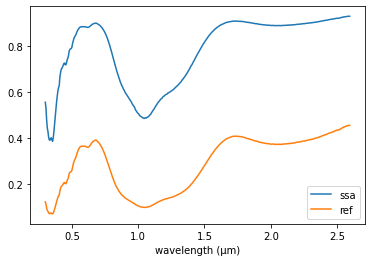

In [40]:
main()